In [1]:
import numpy as np
import matplotlib.pyplot as plt
from MyAdaboost import MyAdaboost
%matplotlib inline

In [2]:
def loadSimpData():
    datMat = np.matrix([[1., 2.1],
                       [2., 1.1],
                       [1.3, 1.],
                       [1., 1.],
                       [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [3]:
X, y = loadSimpData()

In [4]:
adaboost= MyAdaboost(9).fit(X, y)

In [5]:
adaboost.predict([1.3,1])

matrix([[-1.]])

adaboost 算法的输入参数包含数据集，标签，以及迭代次数，其中迭代次数参数是整个adaboost算法中唯一需要用户指定的参数。

这里怎么思考权重向量D是一个概率分布向量？因为所有的元素之和为1.列向量aggClassEst记录每个数据点的类别估计累计值。

## 测试算法：基于AdaBoost的分类

In [6]:
adaboost.predict([0,0])

matrix([[-1.]])

In [7]:
adaboost.predict([[5,5],[0,0]])

matrix([[ 1.],
        [-1.]])

## 在难数据集上应用AdaBoost

In [8]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = [];
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat


In [9]:
X, y = loadDataSet('data/horseColicTraining2.txt')
X = np.mat(X)

In [10]:
myadaboost = MyAdaboost(50).fit(X, y)

In [11]:
testArr, testLabelArr = loadDataSet('data/horseColicTest2.txt')
testArr = np.mat(testArr)
prediction10 = myadaboost.predict(testArr)
errArr = np.mat(np.ones((67,1)))
errArr[prediction10!=np.mat(testLabelArr).T].sum()/67.0

0.20895522388059701

迭代次数越多，意味着生成尽可能多的单层决策树使得数据集尽可能的被正确分开。这也表示，迭代次数越多，模型对数据的拟合越好，就会出现过拟合的情况！

# 非均衡分类问题
通常情况下，我们假设所有类别的分类代价是一样的，但是在某些问题中类别之间的误差代价不是一样的。比如过滤垃圾邮件，我们可以容忍一些垃圾邮件出现在正常邮件里，而不允许正常邮件当做垃圾邮件来处理。
所以，**在实际生活中，不同类别的分类代价并不相等**。

## 分类器性能度量方法
- 精确率(precision)
- 召回率(recall）
- ROC曲线

很多时候，都是基于正确率来衡量分类器任务的成功程度的。错误率指的是在所有测试样例中错分的样例比例。实际上，这样的错误度量掩盖了样例如何被错分的事实。机器学习中，可以利用混淆矩阵(confusion matrix)的工具，它可以帮助人们更好地了解分类中的错误。
如果混淆矩阵中的非对角元素均为0，就会得到一个完美的分类器。
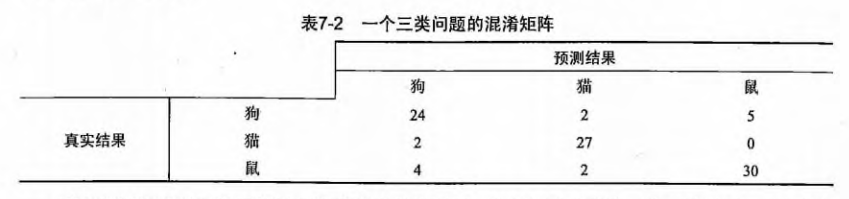
在分类中，当某个类别的重要性高于其他类别时，我们就可以利用上述定义来定义出多个比错误率更好的新指标。
- 第一个指标是精确率(precision),它等于TP/(TP+FP),表示预测为正样本的数据中，真正的正样本所占的比例。
- 第二个指标是召回率(recall),它等于TP/(TP+FN),表示正样本被正确分类的数量占真正的所有正样本数量的比例。
   在召回率很大的分类器中，真正判错的正例的数目并不多
> 我们很容易构造一个高正确率或高召回率的分类器，但很难同时兼顾这两种性能度量。
- 第三个指标是用于度量分类中的非均衡性的工具，即ROC曲线。ROC代表接收者操作特征。
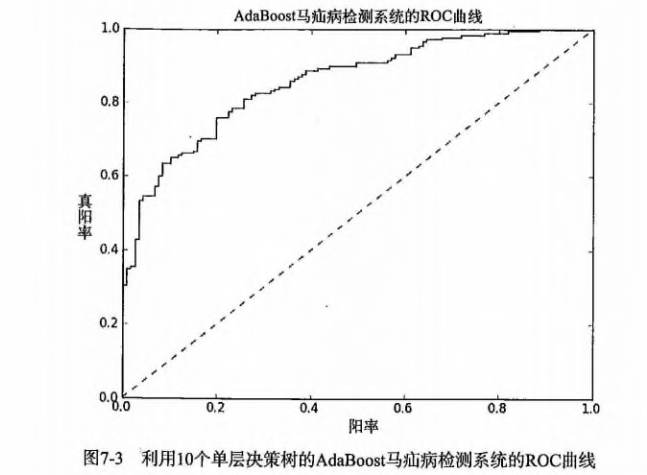

上图中，给出了两条线，一条虚线一条实线。图中横轴是伪正例的比例(假阳率=FP/(FP+TN)),而纵轴是真正例的比例(真阳率=TP/(TP+FN)),ROC曲线给出的是当阈值变化时假阳率和真阳率的变化情况。左下角的点所对应的是将所有样例判为反例的情况，而右上角的点对应的则是将所有样例判为正例的情况。虚线给出的是随机猜测的结果曲线。
>ROC曲线不仅可以用于比较分类器，还可以基于成本效益(cost-versus-benefit）分析来做出决策。

从图中我们可以找到最佳分类器在左上角，意味着分类器的假阳率很低的同时获得了很高的真阳率。例如在垃圾邮件的过滤中，这就相当于过滤了所有的垃圾邮件，单没有将任何合法邮件误识为垃圾邮件而放入垃圾邮件的文件夹中。

- 对不同的ROC曲线进行比较的一个指标是曲线下的面积(AUC,Area Unser the Curve)。AUC给出的是分类器的平均性能值，当然它并不能完全代替对整条曲线的观察。一个完美的分类器的AUC为1，随机猜测的AUC则为0.5

In [12]:
#ROC曲线的绘制及AUC计算函数
def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX=xStep
            delY=yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ", ySum*xStep)

In [14]:
datArr,labelArr = loadDataSet('data/horseColicTraining2.txt')
datArr = np.mat(datArr)

In [15]:
myadaboost = MyAdaboost(10).fit(datArr, labelArr)

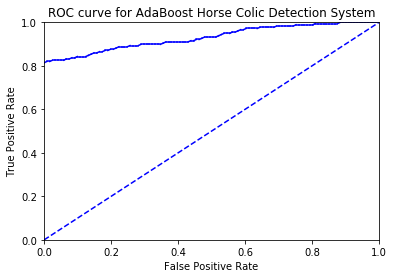

('the Area Under the Curve is: ', 0.8582969635063604)


In [16]:
plotROC(myadaboost.aggClassEst_.T, labelArr)

# 基于代价函数的分类器决策控制

除了调节分类器的阈值外，我们还有一些其他可以用于处理非均匀分类代价问题的方法，其中一种为代价敏感的学习(cost-sensitive learning)。代价矩阵如图所示：
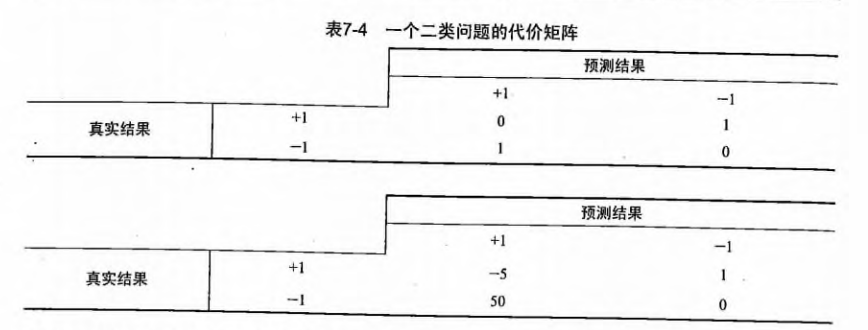

另外一种针对非均衡问题调节分类器的方法，就是对分类器的训练数据进行改造。这可以通过欠抽样(undersampling)或者过抽样(oversampling）来实现。过抽样意味着复制样例，而欠抽样意味着删除样例。不管采用哪种方式，数据都会从原始形式改造为新形式。抽样过程则可以通过随机方式或者某个预定方式来实现。

通常会存在某个罕见的类别需要我们来识别，比如信用卡欺诈。我们应该尽可能的保留这种罕见类别的信息，因此我们应该保留正例类别中的所有样例，而对反例类别进行欠抽样或样例删除处理。这种方法的缺点在于要确定哪些样例需要进行剔除，但是在选择剔除的样例中可能懈怠了剩余样例中并不包含的有效信息。
上述问题的一种解决方法，就是**选择哪些离决策边界较远的样例进行删除**。
比如50例信用卡欺诈交易和5000例合法交易，仅使用负样本欠抽样的，直接删除4950个负样本的做法过于极端。使用一种替代策略就是使用反例类别的欠抽样和正例类别的过抽样相混合的方法。